# Basic time series analysis and lordototale forcast for the period

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prophet
import seaborn as sns
sns.set()
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet
%matplotlib inline

In [3]:
#!pip install prophet

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Upload the data and observe the structure

Provided dataset contains daily data about gross earnings for the each of 5 restaurants for a fixed period: starting from 1 January 2018 till 2 May 2023.

We can mention that for the first 8 months, there is no daily data in the target variable "lordototale", but only monthly data. Starting from 1 September 2018 till 2 May 2023 dataset contains daily data about "lordototale". 

Therefore we decided to remove those rows that do not contain daily data of "lordototale". This decision was made for saving the original structure of the dataset (there are only 8 months with inconsistent data, and we still have almost 5 years of daily data of gross earnings for restaurants). Another way how to deal with this problem can be to spread average monthly data for each day, but we have enough correct data to avoid this manipulation. 

In [5]:
data = pd.read_csv("/content/gdrive/MyDrive/DSLab_project/ristoranti.csv", delimiter=';')

# we need to remove data till 2018-09-01, index for this row = 1209
n = 1210
data.drop(index=data.index[:n], axis=0, inplace=True)

# starting from 2023-05-03 no data
m = 169
data.drop(data.tail(m).index,inplace = True)

# change var type from int to datetime
data['date'] = pd.to_datetime(data['data'], format='%Y%m%d')
data = data.drop("data", axis=1)

data = data[['date', 'lordototale', 'ristorante']]
data = data.rename(columns={'date': 'ds', 'lordototale': 'y'})


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9809 entries, 1210 to 11018
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          9809 non-null   datetime64[ns]
 1   y           9809 non-null   float64       
 2   ristorante  9809 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 230.0+ KB


In [8]:
# form dataset for each of the restaurant
data_montebello =  data[data["ristorante"]=="R000"].reset_index(drop=True)
data_piacenza_1 =  data[data["ristorante"]=="R001"].reset_index(drop=True)
data_stradella =  data[data["ristorante"]=="R004"].reset_index(drop=True)
data_voghera =  data[data["ristorante"]=="R005"].reset_index(drop=True)
data_piacenza_2 =  data[data["ristorante"]=="R002"].reset_index(drop=True)


In [9]:
def plot_rest(data): 
    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize':(30,6)})
    ax = sns.lineplot(data = data, x = data.ds, y = data.y,
                      label=data.ristorante[0], lw=1)
    plt.title(f'Daily earning for the restaurant {data.ristorante[0]}', fontsize=25)
    plt.ylabel('Lordototale', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.show()

Let's observe time series for some restaurants separately

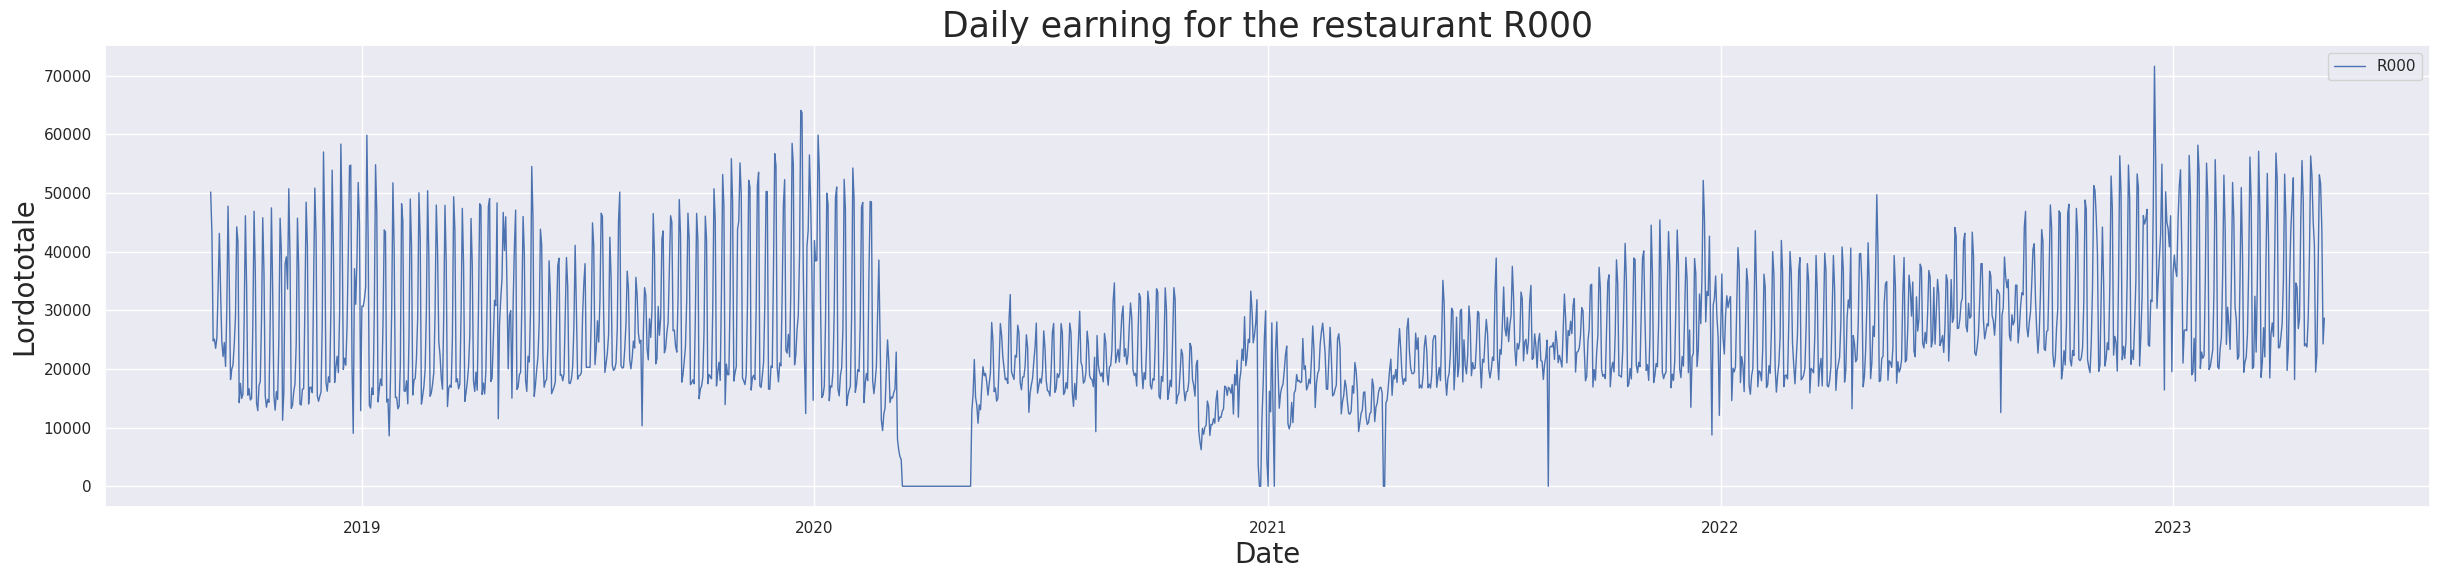

In [76]:
plot_rest(data_montebello)

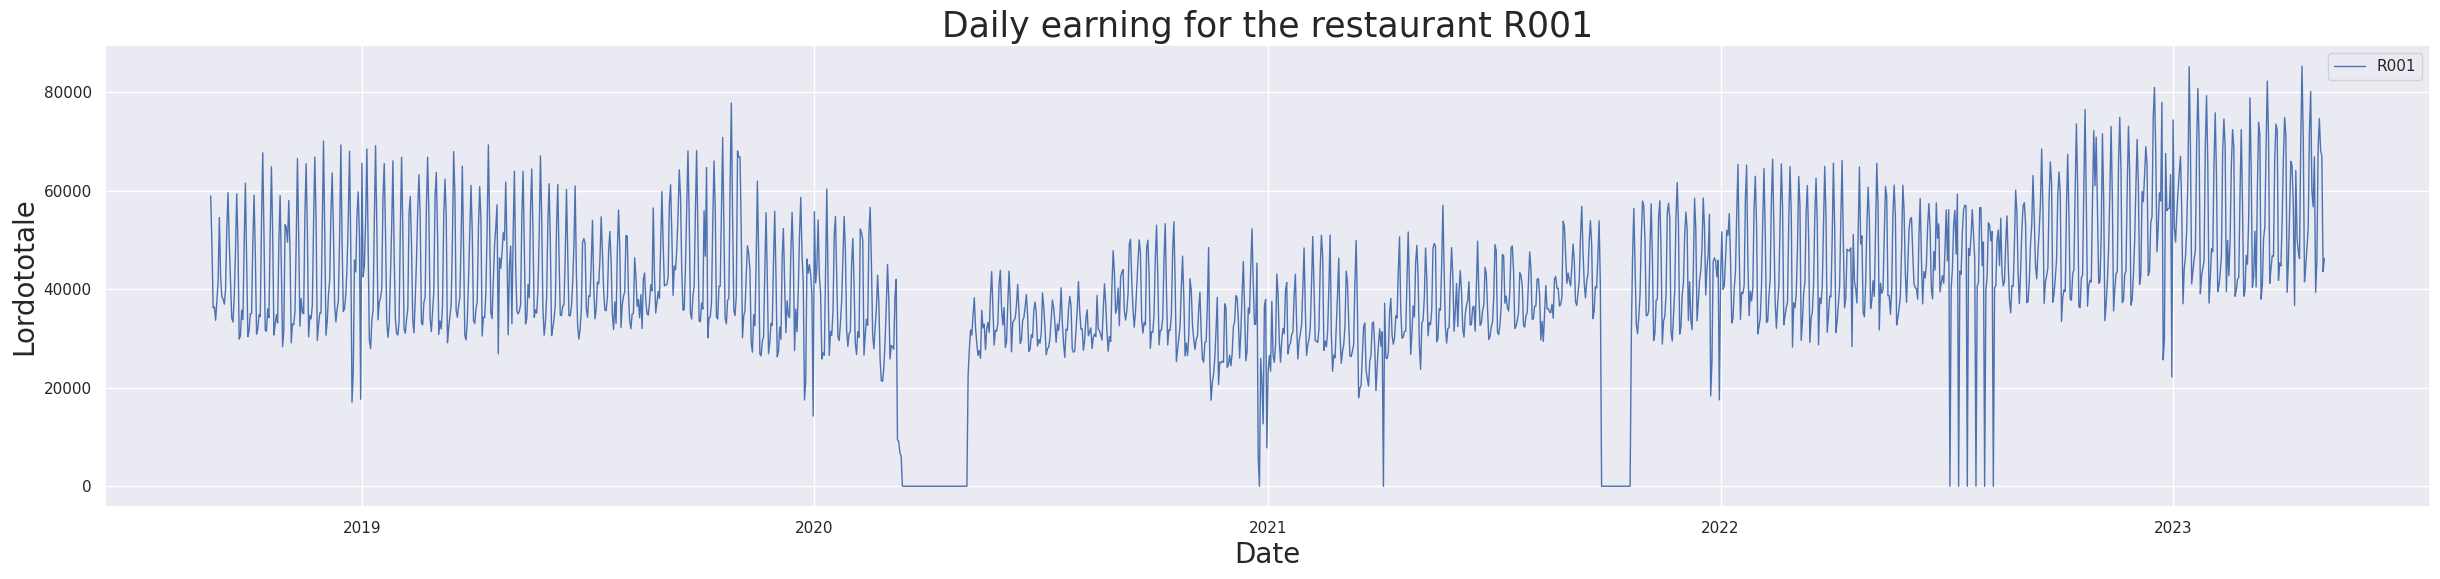

In [77]:
plot_rest(data_piacenza_1)

Looking at this graphs we can say that before the beginning of 2020 the series is most likely stationary but after the sharp decline it is not stationary as we can see a clear trend.

It can also be noted that the data can be divided into 3 periods, before covid, during covid, and after covid. Each of these periods has its own data structure, which we want to explore further. For this, we will divide the dataset into 3 separate time periods and conduct their analysis (on the example of one restaurant).

As we can see above, there is a clear weekly seasonality. Every week, we see a peak towards Saturday, and the lowest points are in the middle of the week.

## Exploratory Data Analysis (EDA)

In [78]:
# choosing ristorante R001 in Piacenza

data_piacenza_1

,ds,y,ristorante
0,2018-09-01,58917.8366,R001
1,2018-09-02,48995.3464,R001
2,2018-09-03,36185.5732,R001
3,2018-09-04,36402.4808,R001
4,2018-09-05,33679.4066,R001
...,...,...,...
1701,2023-04-29,74606.3437,R001
1702,2023-04-30,68179.6507,R001
1703,2023-05-01,67024.9027,R001
1704,2023-05-02,43551.6347,R001


In [10]:
# cut 3 different period into 3 dataframes

# first period before covid till first lockdown in 2020-03-09
data_p1_1 = data_piacenza_1[data_piacenza_1['ds'] < '2020-03-09']

# second period during covid till last lockdown in 2021-01-05
data_p1_2 = data_piacenza_1[data_piacenza_1['ds'] > '2020-03-08']
data_p1_2 = data_p1_2[data_p1_2['ds'] <= '2021-12-27']

# third period after covid from 2021-01-05
data_p1_3 = data_piacenza_1[data_piacenza_1['ds'] > '2021-12-28']



In [11]:
data_p1_1

,ds,y,ristorante
0,2018-09-01,58917.8366,R001
1,2018-09-02,48995.3464,R001
2,2018-09-03,36185.5732,R001
3,2018-09-04,36402.4808,R001
4,2018-09-05,33679.4066,R001
...,...,...,...
550,2020-03-04,28262.8290,R001
551,2020-03-05,27816.3760,R001
552,2020-03-06,38489.6176,R001
553,2020-03-07,41996.8962,R001


In [12]:
data_p1_2

,ds,y,ristorante
555,2020-03-09,9082.1178,R001
556,2020-03-10,6714.3062,R001
557,2020-03-11,6121.1556,R001
558,2020-03-12,0.0000,R001
559,2020-03-13,0.0000,R001
...,...,...,...
1209,2021-12-23,55178.9063,R001
1210,2021-12-24,18338.5629,R001
1211,2021-12-25,24956.3097,R001
1212,2021-12-26,45520.2405,R001


In [13]:
data_p1_3

,ds,y,ristorante
1215,2021-12-29,42511.4529,R001
1216,2021-12-30,45868.9364,R001
1217,2021-12-31,17524.7464,R001
1218,2022-01-01,42263.2812,R001
1219,2022-01-02,51611.7427,R001
...,...,...,...
1701,2023-04-29,74606.3437,R001
1702,2023-04-30,68179.6507,R001
1703,2023-05-01,67024.9027,R001
1704,2023-05-02,43551.6347,R001


Let's apply the Dickey-Fuller test to see if it is a stationary process

In [14]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        


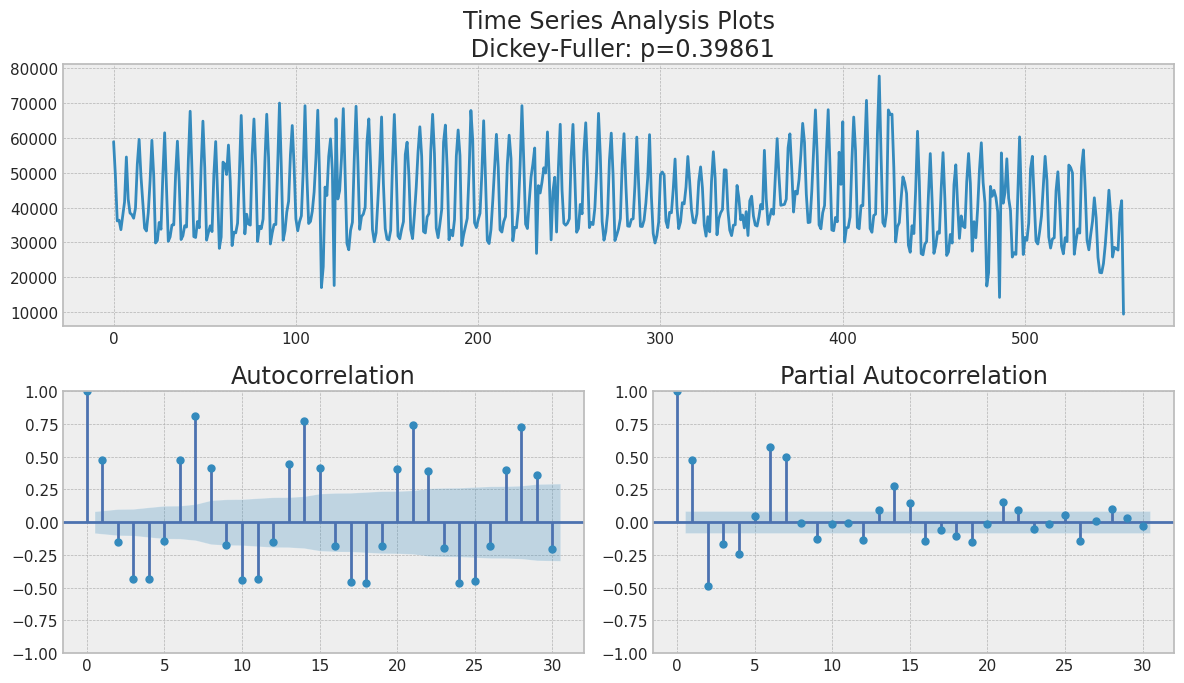

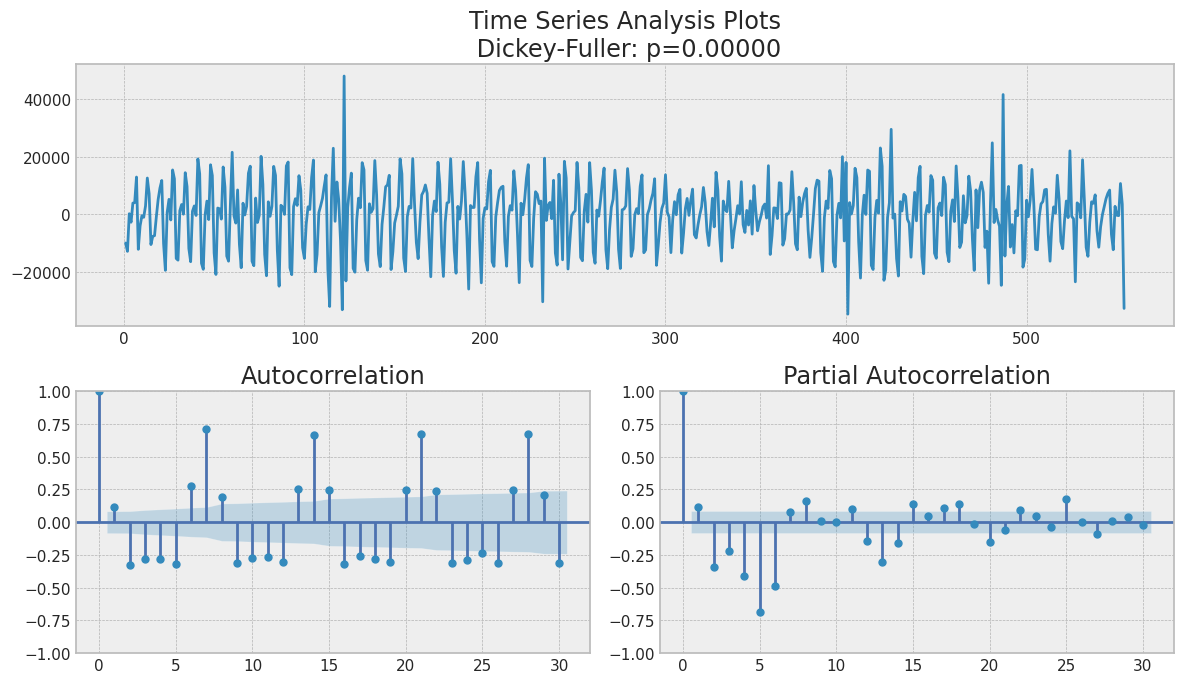

In [17]:
tsplot(data_p1_1.y, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data_p1_1.y - data_p1_1.y.shift(1)

tsplot(data_diff[1:], lags=30)

Time series of the first period is not stationary and has weekly seasonality

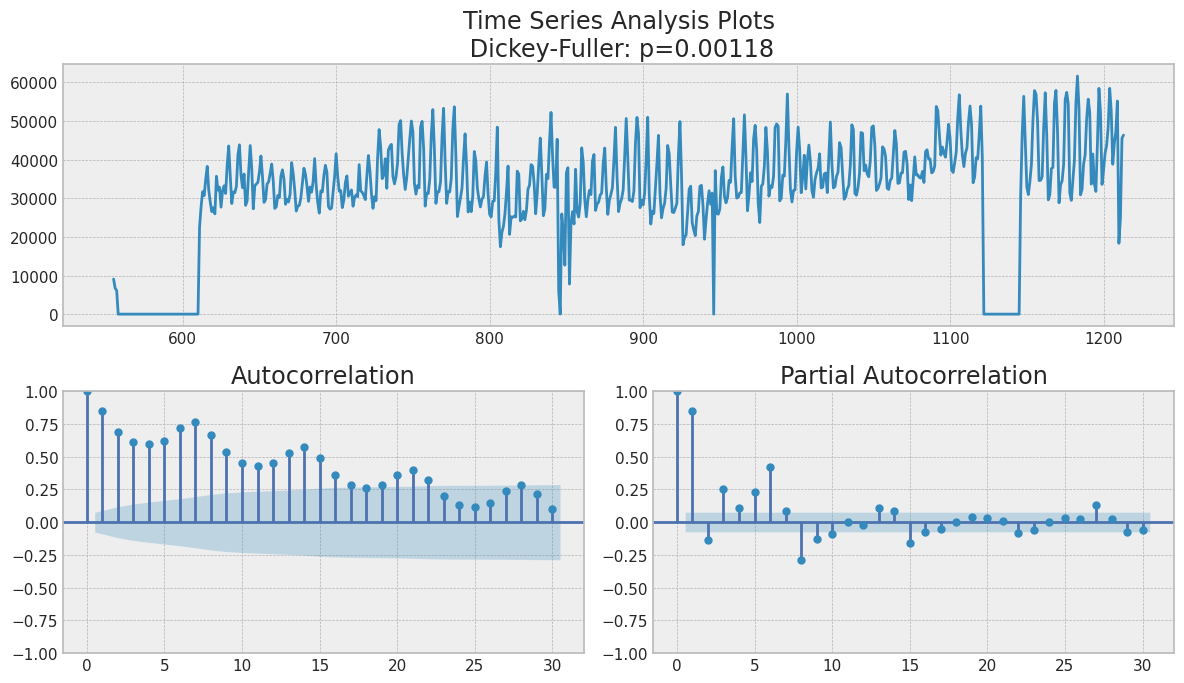

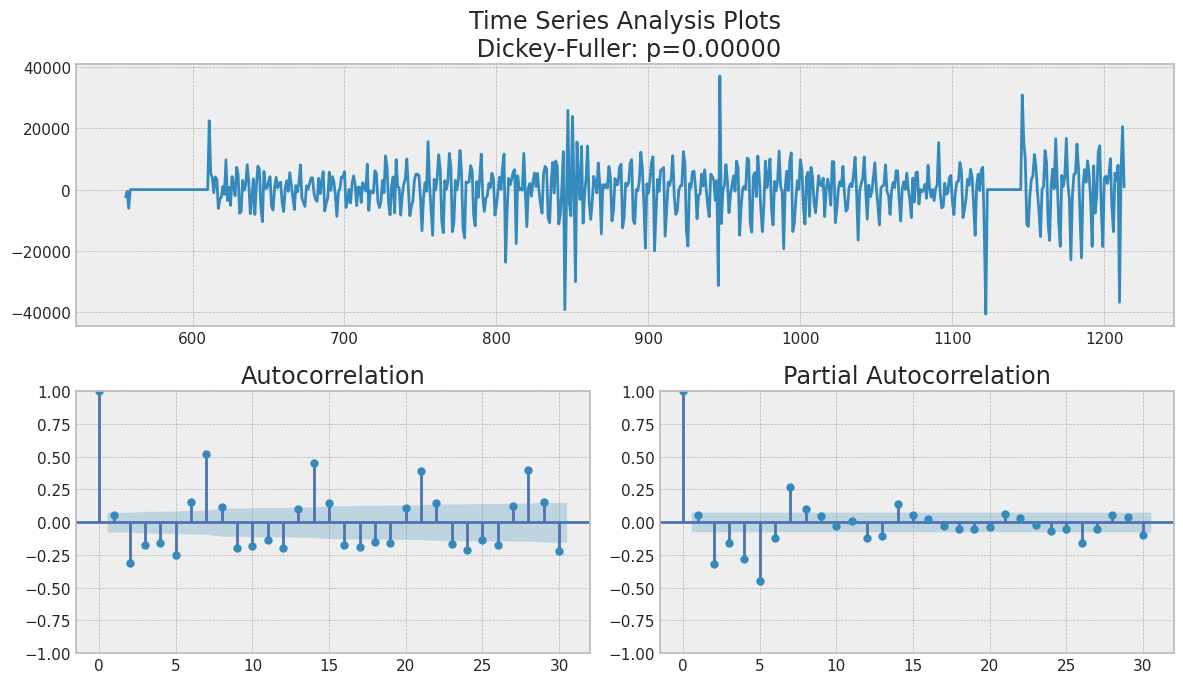

In [18]:
tsplot(data_p1_2.y, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data_p1_2.y - data_p1_2.y.shift(1)

tsplot(data_diff[1:], lags=30)

Time series of the second period is stationary and has weekly seasonality

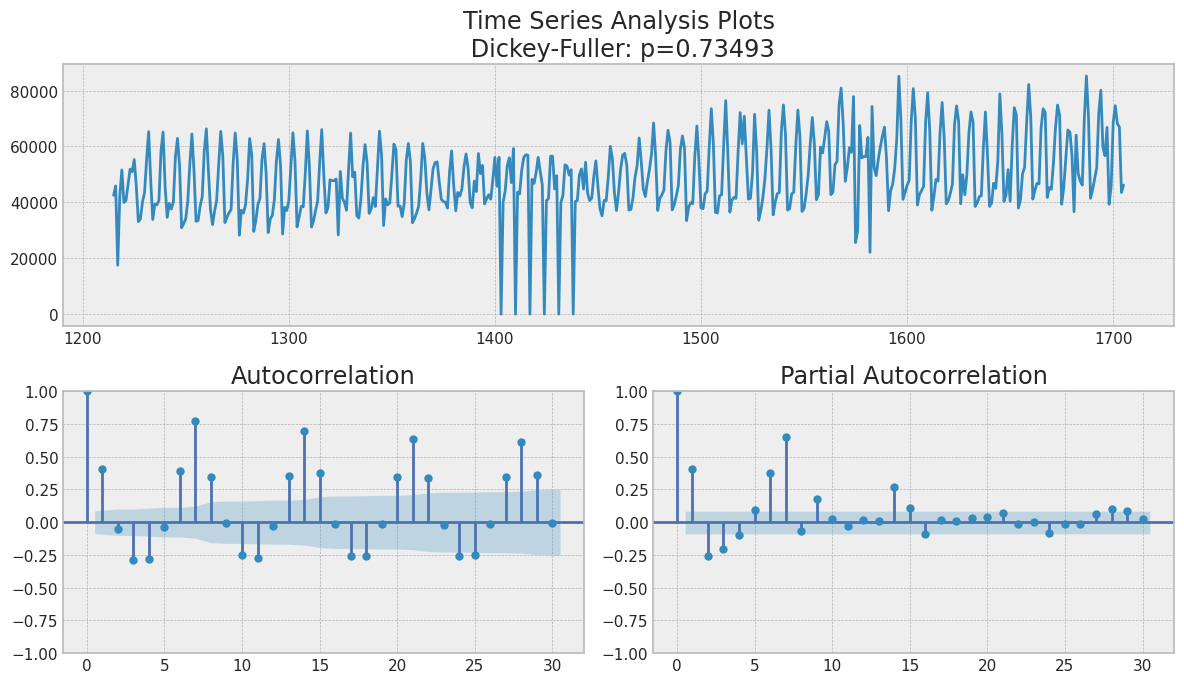

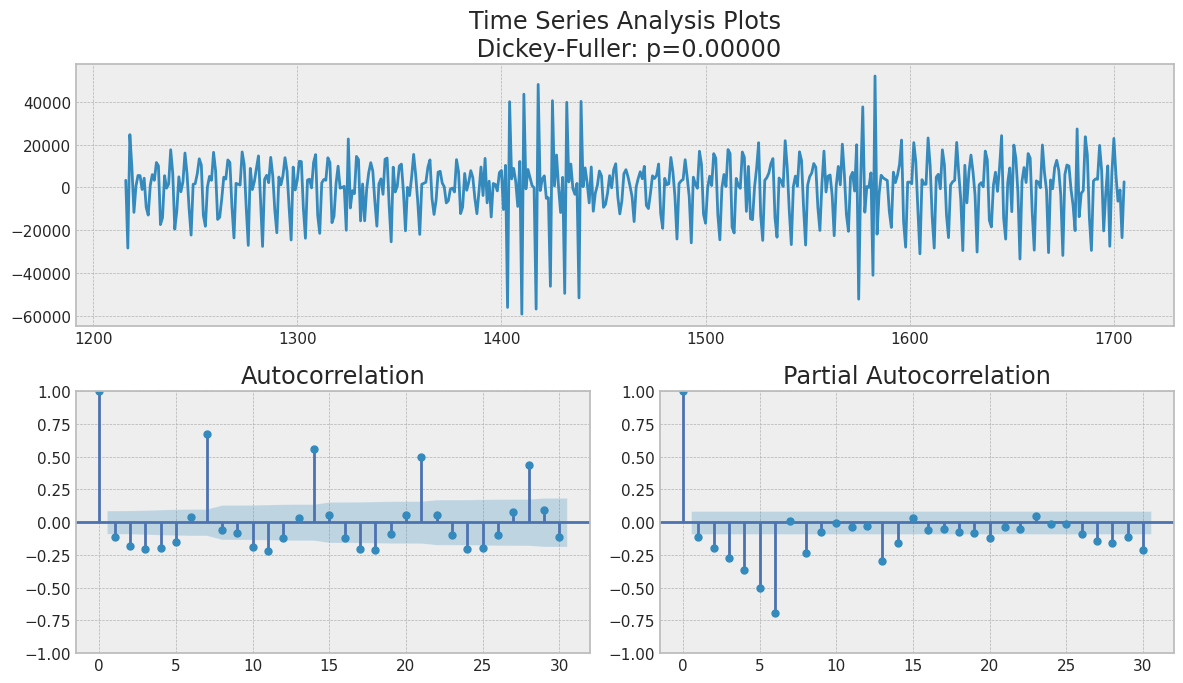

In [19]:
tsplot(data_p1_3.y, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data_p1_3.y - data_p1_3.y.shift(1)

tsplot(data_diff[1:], lags=30)

Time series of the first period is not stationary and has weekly seasonality

## Check trend and seasonality character for each period 
using Prophet model (as our choosen model for modeling)

In [20]:
dates1 = data_p1_1[['ds']]
dates2 = data_p1_2[['ds']]
dates3 = data_p1_3[['ds']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3tp1p4r/_zvutzvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3tp1p4r/1ide_wky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23428', 'data', 'file=/tmp/tmpq3tp1p4r/_zvutzvg.json', 'init=/tmp/tmpq3tp1p4r/1ide_wky.json', 'output', 'file=/tmp/tmpq3tp1p4r/prophet_modeld62hrx8n/prophet_model-20230605174207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


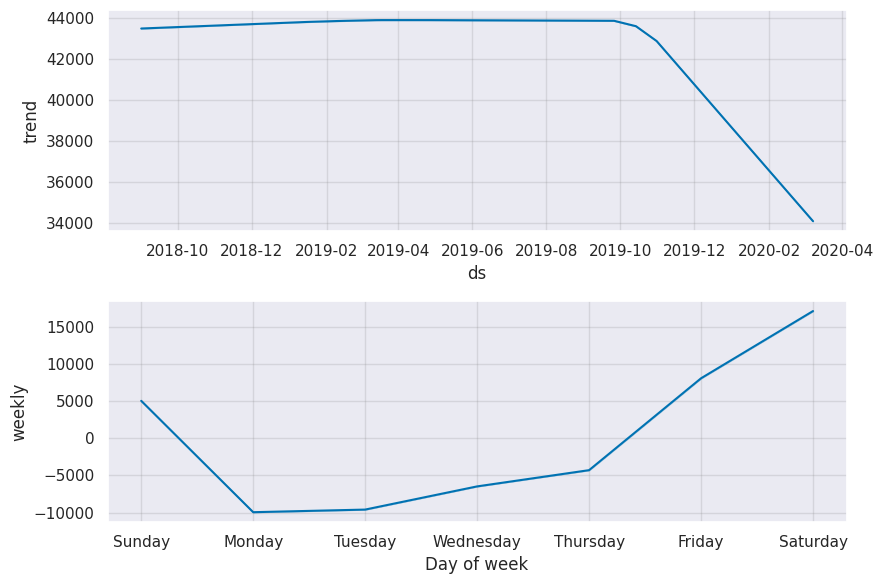

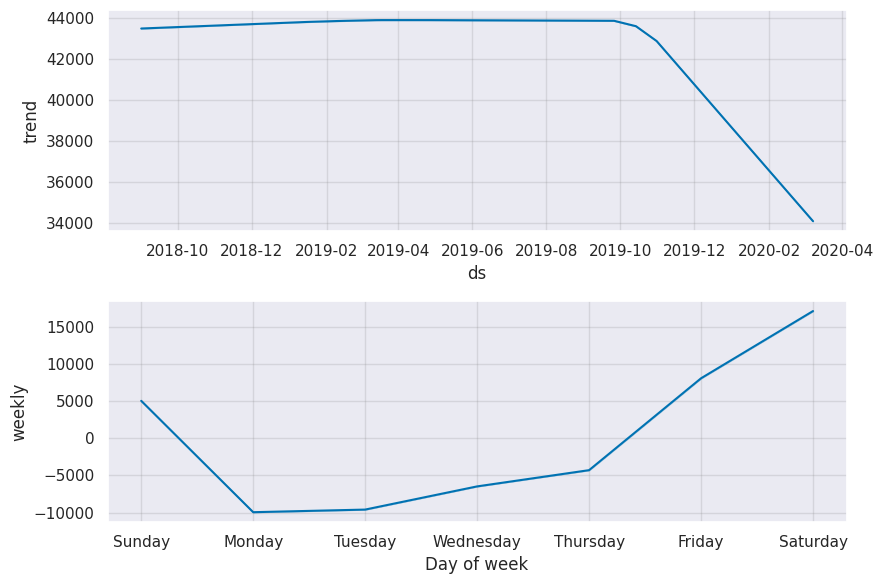

In [21]:
model1 = Prophet()
model1.fit(data_p1_1)
forecast1 = model1.predict(dates1)
model1.plot_components(forecast1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3tp1p4r/4luiys7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3tp1p4r/_uod3a6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86416', 'data', 'file=/tmp/tmpq3tp1p4r/4luiys7l.json', 'init=/tmp/tmpq3tp1p4r/_uod3a6i.json', 'output', 'file=/tmp/tmpq3tp1p4r/prophet_modelspahjat9/prophet_model-20230605174209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


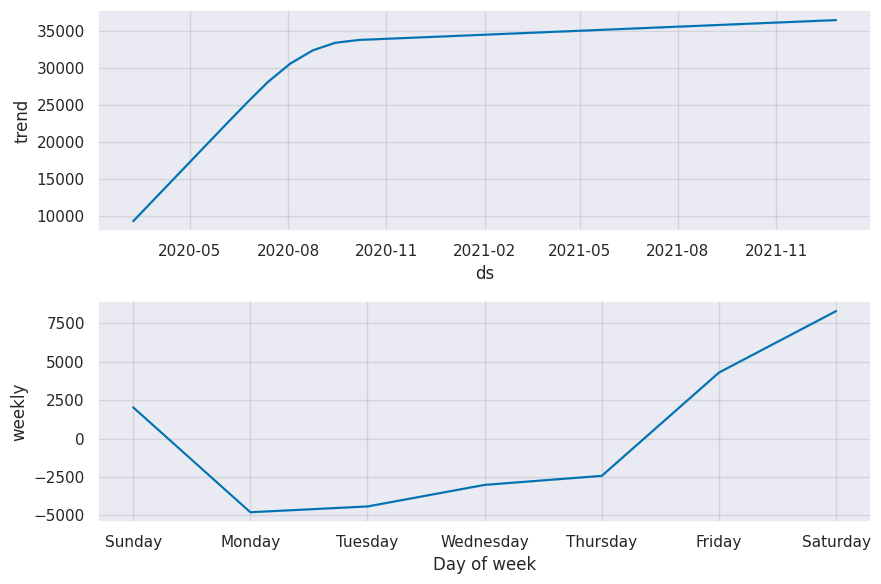

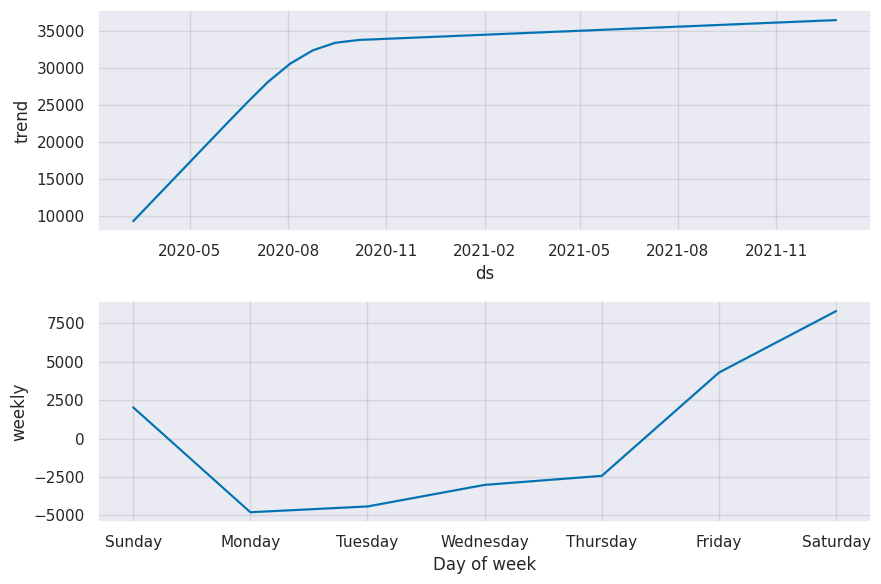

In [22]:
model2 = Prophet()
model2.fit(data_p1_2)
forecast2 = model2.predict(dates2)
model2.plot_components(forecast2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3tp1p4r/d9fa_kby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3tp1p4r/fgkxs79v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43471', 'data', 'file=/tmp/tmpq3tp1p4r/d9fa_kby.json', 'init=/tmp/tmpq3tp1p4r/fgkxs79v.json', 'output', 'file=/tmp/tmpq3tp1p4r/prophet_modelh1a6fk0q/prophet_model-20230605174212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


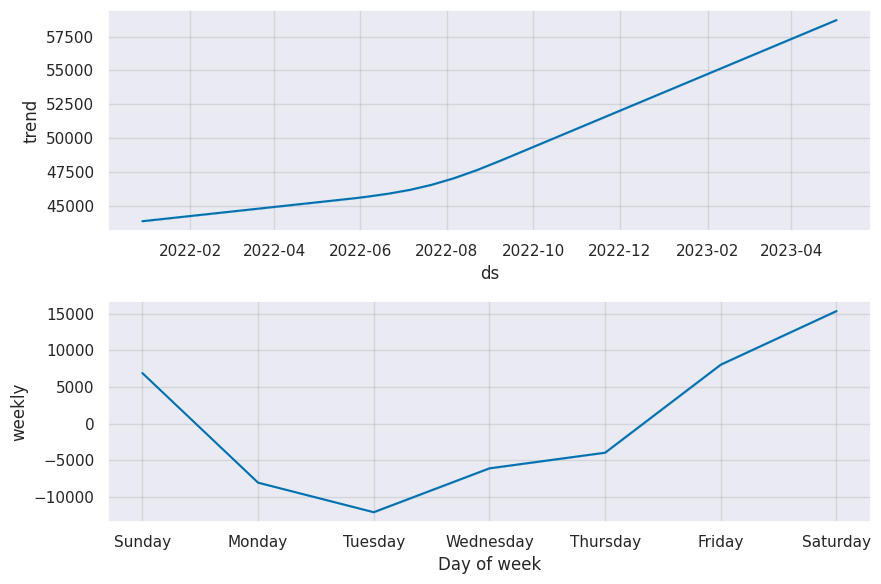

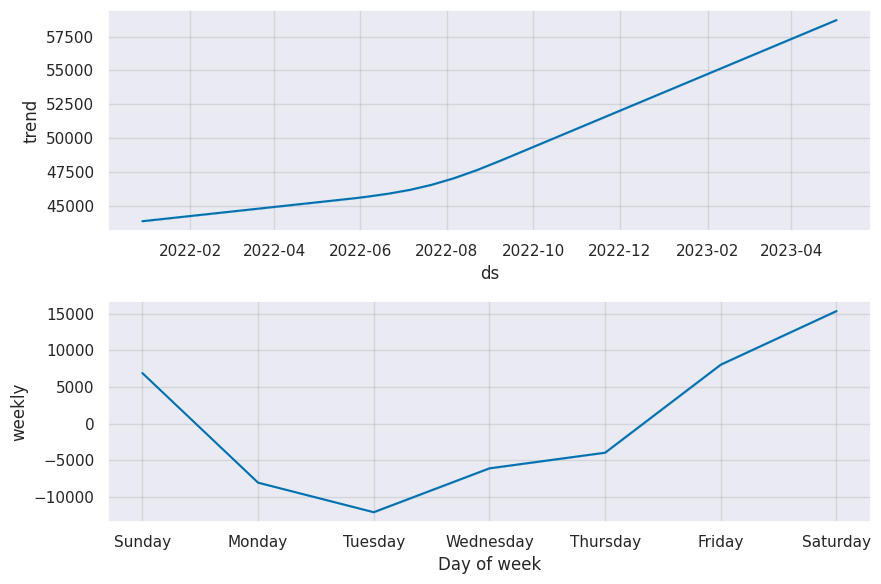

In [23]:
model3 = Prophet()
model3.fit(data_p1_3)
forecast3 = model3.predict(dates3)
model3.plot_components(forecast3)

Therefore, all three periods have a different data structure, the trend is significantly different in them, the seasonality in all three is weekly, but has a different character. Also the third time period has annual seasonality (but this can be explained by the fact that only this time period has 2 full years of data)